# Simulation: Personalisation vs Re-identification Trade-off

This notebook demonstrates, via numerical simulation, the trade-off between **personalisation (individual-level precision)** and **re-identification risk (identifiability)**.  
It follows the idea that finer-grained data allows better personal prediction but increases the risk of re-identifying individuals.

---

### Overview

- We simulate a population of individuals described by 6 correlated variables (range 1–36).  
- We vary the **discretisation granularity** (number of bins) from 36 down to 2.  
- We measure:
  - **Re-identification success**: ability to identify an individual from their first variable and learned correlations.
  - **Prediction accuracy**: ability to predict a clinical outcome (X6) from other variables.

The results should show that **reducing identifiability** (via coarser discretisation) **reduces personalisation** (predictive accuracy).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math, random

random.seed(0)
np.random.seed(0)


In [2]:
def make_cov(d=6, strong_pairs=None, base_corr=0.2, strong_corr=0.7):
    Sigma = np.full((d,d), base_corr)
    np.fill_diagonal(Sigma, 1.0)
    if strong_pairs:
        for (i,j) in strong_pairs:
            Sigma[i,j] = Sigma[j,i] = strong_corr
    return Sigma

N_total = 100000
n_train = 60000
n_release = 40000
d = 6
bins_base = 100
bins_list = [100, 50, 36, 18, 12, 9, 6, 4, 3, 2]

strong_pairs = [(0,1), (1,2), (2,3)]
Sigma = make_cov(d=d, strong_pairs=strong_pairs)
mu = np.zeros(d)
latent = np.random.multivariate_normal(mu, Sigma, size=N_total)

def to_base_categories(latent, bins=bins_base):
    arr = np.zeros_like(latent, dtype=int)
    for j in range(latent.shape[1]):
        ranks = latent[:,j].argsort().argsort()
        arr[:,j] = (ranks / (len(ranks)/bins)).astype(int) + 1
        arr[arr[:,j] > bins, j] = bins
    return arr

base_cat = to_base_categories(latent)


/var/folders/dl/r9vp90j14fzf894140tnfs4h0000gn/T/ipykernel_70237/1628769454.py:19: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  latent = np.random.multivariate_normal(mu, Sigma, size=N_total)


In [3]:
Sigma

array([[1. , 0.7, 0.2, 0.2, 0.2, 0.2],
       [0.7, 1. , 0.7, 0.2, 0.2, 0.2],
       [0.2, 0.7, 1. , 0.7, 0.2, 0.2],
       [0.2, 0.2, 0.7, 1. , 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 1. , 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2, 1. ]])

In [4]:
idx = np.arange(N_total)
np.random.shuffle(idx)
train_idx = idx[:n_train]
release_idx = idx[n_train:n_train+n_release]

latent_train = latent[train_idx]
latent_release = latent[release_idx]
base_train = base_cat[train_idx]
base_release = base_cat[release_idx]

def coarsen_categories(base_arr, bins):
    if bins == bins_base:
        return base_arr.copy()
    factor = bins_base / bins
    new = np.ceil(base_arr / factor).astype(int)
    new[new>bins] = bins
    return new


In [5]:
def identification_experiment(latent_train, base_train, latent_release, base_release, bins):
    train_coarse = coarsen_categories(base_train, bins)
    release_coarse = coarsen_categories(base_release, bins)
    d = latent_train.shape[1]

    cond_stats = {}
    for cat in range(1, bins+1):
        mask = train_coarse[:,0] == cat
        if mask.sum() < 5:
            cond_mean = latent_train[:,1:].mean(axis=0)
            cond_cov = np.cov(latent_train[:,1:].T) + np.eye(d-1)*1e-6
        else:
            cond_mean = latent_train[mask][:,1:].mean(axis=0)
            cond_cov = np.cov(latent_train[mask][:,1:].T) + np.eye(d-1)*1e-6
        cond_stats[cat] = (cond_mean, cond_cov)

    trials = 800
    ids = np.random.choice(latent_release.shape[0], size=trials, replace=False)
    top1_success, avg_rank = 0, 0.0

    for tidx in ids:
        true_cat = release_coarse[tidx,0]
        mean, cov = cond_stats[true_cat]
        candidates = latent_release[:,1:]
        logps = multivariate_normal.logpdf(candidates, mean=mean, cov=cov)
        ranks = (-logps).argsort().argsort() + 1
        true_rank = ranks[tidx]
        avg_rank += true_rank
        if true_rank == 1:
            top1_success += 1
    avg_rank /= trials
    success_rate = top1_success / trials
    return success_rate, avg_rank


In [6]:
def predictive_experiment(latent_train, base_train, latent_release, base_release, bins):
    train_coarse = coarsen_categories(base_train, bins)
    release_coarse = coarsen_categories(base_release, bins)
    Xtr = train_coarse[:,:5].astype(float)
    Xte = release_coarse[:,:5].astype(float)
    ytr = latent_train[:,5]
    yte = latent_release[:,5]
    model = LinearRegression().fit(Xtr, ytr)
    preds = model.predict(Xte)
    rmse = math.sqrt(mean_squared_error(yte, preds))
    r2 = model.score(Xte, yte)
    return rmse, r2


In [7]:
results = []
for b in bins_list:
    success, avg_rank = identification_experiment(latent_train, base_train, latent_release, base_release, b)
    rmse, r2 = predictive_experiment(latent_train, base_train, latent_release, base_release, b)
    results.append(dict(bins=b, id_top1_success=success, id_avg_rank=avg_rank, pred_rmse=rmse, pred_r2=r2))

df = pd.DataFrame(results).sort_values('bins', ascending=False)
df


,bins,id_top1_success,id_avg_rank,pred_rmse,pred_r2
0,100,0.00000,5531.99375,0.959736,0.086342
1,50,0.00000,5605.99750,0.959724,0.086366
2,36,0.00125,5851.77625,0.959828,0.086167
3,18,0.00000,5846.26625,0.960074,0.085699
4,12,0.00000,6391.64750,0.960125,0.085603
5,9,0.00000,6426.74625,0.960685,0.084536
6,6,0.00000,7852.03250,0.961014,0.083907
7,4,0.00000,9098.26000,0.962549,0.080979
8,3,0.00000,10829.20750,0.964164,0.077893
9,2,0.00000,13164.71125,0.968980,0.068658


In [8]:
base_train 

array([[37, 21,  8, 17,  3, 84],
       [47, 13, 20, 65, 90,  3],
       [21, 21, 27, 29, 57, 26],
       ...,
       [44, 12, 12, 54,  2, 22],
       [28, 14, 12, 20, 34, 68],
       [99, 92, 55, 69, 20, 92]], shape=(60000, 6))

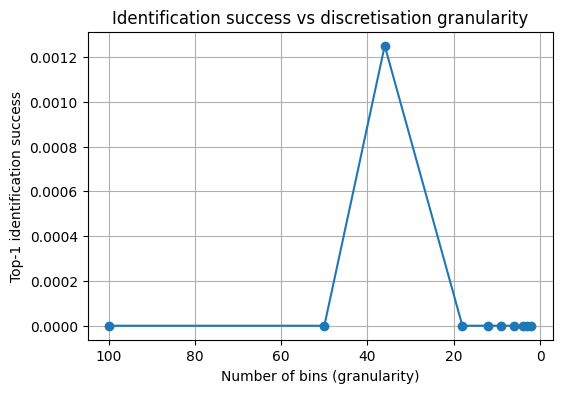

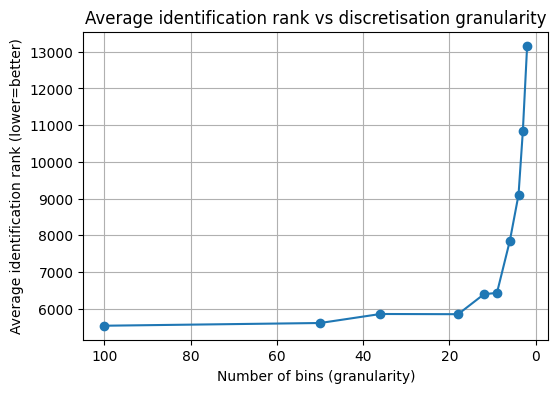

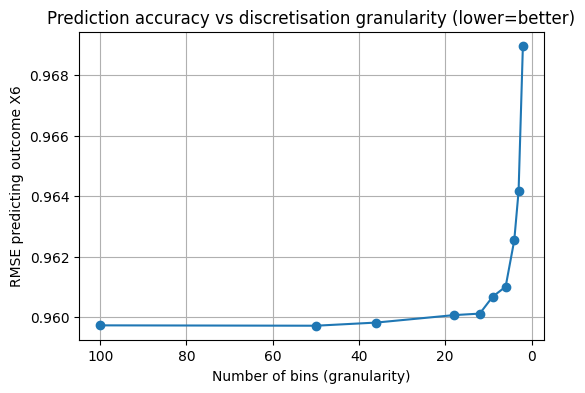

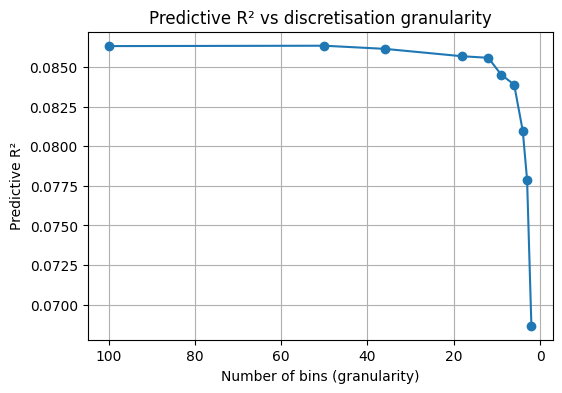

In [9]:
plt.figure(figsize=(6,4))
plt.plot(df['bins'], df['id_top1_success'], marker='o')
plt.xlabel('Number of bins (granularity)')
plt.ylabel('Top-1 identification success')
plt.title('Identification success vs discretisation granularity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(df['bins'], df['id_avg_rank'], marker='o')
plt.xlabel('Number of bins (granularity)')
plt.ylabel('Average identification rank (lower=better)')        
plt.title('Average identification rank vs discretisation granularity')
plt.gca().invert_xaxis()
plt.grid(True)

plt.figure(figsize=(6,4))
plt.plot(df['bins'], df['pred_rmse'], marker='o')
plt.xlabel('Number of bins (granularity)')
plt.ylabel('RMSE predicting outcome X6')
plt.title('Prediction accuracy vs discretisation granularity (lower=better)')
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(df['bins'], df['pred_r2'], marker='o')
plt.xlabel('Number of bins (granularity)')
plt.ylabel('Predictive R²')
plt.title('Predictive R² vs discretisation granularity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()
